In [3]:
import os
import copy
import numpy as np
import numpy.ma as ma
import rioxarray
import xarray as xr
import rasterio
import time
from functools import wraps
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, PREFERRED_CRS
from src.data_loading.landcover_plot_utils import classes_to_rgb
SAT_DIR = "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data"
import matplotlib.patches as mpatches
from rasterio.plot import show
from src.data_loading.landcover_plot_utils import classes_to_rgb

## Look at classes in original ESA CCI data

In [4]:
input_filepaths = [GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson" for year in range(1992, 2016)]

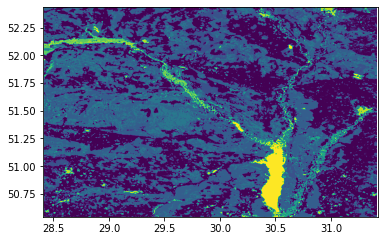

<AxesSubplot:>

In [5]:
chernobyl_2015_wgs84 = rasterio.open(input_filepaths[-1])
show(chernobyl_2015_wgs84)

Make a function to map from esa cci classes to new classes. 

Todo: tidy up 

In [55]:
def old_to_new_classes(input_array):
    '''input xarray.DataArray with esa cci classes and output dataarray with new classes
        but same coords and attributes as input'''
    new_class_1 = np.where((input_array == 10)|(input_array == 11)|(input_array == 12)
                             |(input_array == 20)|(input_array == 30)|(input_array == 40), 
                             1, input_array)
    new_class_2 = np.where((input_array == 60)|(input_array == 61)|(input_array == 62)
                             |(input_array == 80)|(input_array == 81)|(input_array == 82)
                             |(input_array == 90)|(input_array == 100), 
                             2, new_class_1)
    new_class_3 = np.where((input_array == 50)|(input_array == 70)|(input_array == 71)
                             |(input_array == 72), 
                             3, new_class_2)
    new_class_4 = np.where((input_array == 160)|(input_array == 170), 
                             4, new_class_3)
    new_class_5 = np.where((input_array == 110)|(input_array == 130), 
                             5, new_class_4)
    new_class_6 = np.where((input_array == 120)|(input_array == 121)|(input_array == 122), 
                             6, new_class_5)
    new_class_7 = np.where((input_array == 190), 
                             7, new_class_6)
    new_class_8 = np.where((input_array == 140)|(input_array == 150)|(input_array == 152)
                             |(input_array == 153)|(input_array == 200)|(input_array == 201)
                             |(input_array == 202)|(input_array == 220), 
                             8, new_class_7)
    new_class_9 = np.where((input_array == 210), 
                             9, new_class_8)
    new_class_10 = np.where((input_array == 180), 
                             10, new_class_9)

    output_array_final = xr.DataArray(data=new_class_10, coords=input_array.coords, attrs=input_array.attrs)
    
    return output_array_final



### Visualise

Looking at the esa cci landcover data from 2015:

<xarray.DataArray (band: 1, y: 681, x: 1086)>
array([[[  0, 100, ...,  60,   0],
        [  0,  60, ..., 100,   0],
        ...,
        [  0,  10, ...,  60,   0],
        [  0,  70, ...,  60,   0]]], dtype=uint8)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 52.43 52.43 52.43 52.43 ... 50.55 50.55 50.55 50.55
  * x        (x) float64 28.41 28.41 28.41 28.42 ... 31.41 31.42 31.42 31.42
Attributes:
    transform:      (0.002777777777778, 0.0, 28.40555555557222, 0.0, -0.00277...
    crs:            +init=epsg:4326
    res:            (0.002777777777778, 0.002777777777778)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
<xarray.DataArray (band: 1, y: 681, x: 1086)>
array([[[0, 2, 2, ..., 2, 2, 0],
        [0, 2, 2, ..., 2, 2, 0],
        [0, 2, 2, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 2, 2, 0],
        [0, 1, 3, ..., 2, 2, 0],
        [0, 3, 3, ..., 2, 2, 0]]], dtype=uint8)
Coo

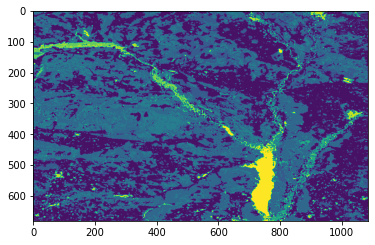

<AxesSubplot:>

In [53]:
#roi_ds = gdal.Open('/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/esa_cci_rois/esa_cci_2015_chernobyl.geojson', gdal.GA_ReadOnly)    

#roi = roi_ds.GetRasterBand(1).ReadAsArray()    #read in data array

roi = xr.open_rasterio('/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/esa_cci_rois/esa_cci_2015_chernobyl.geojson')
classes = np.unique(roi)
print(roi)
print(old_to_new_classes(roi))

#plot original data (20 classes)
rasterio.plot.show(roi)

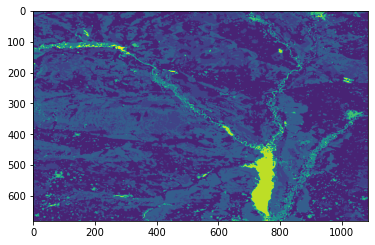

<AxesSubplot:>

In [54]:
#Plot data with new classes (11 classes)
new_classes = np.unique((old_to_new_classes(roi)))

rasterio.plot.show(old_to_new_classes(roi))

In [25]:
new_classes = ['Agriculture','Deciduous forest', 'Evergreen forest', 'Swamp forest', 'Grassland',
              #'Shrubland', 
               'Urban', 'Sparse vegetation', 'Water', 'Wetland', 'No data']

#### Look at the pixel count per class in the original data and new combined class data:

In [26]:
#original data
data_2015=[]
for c in classes:
    data_2015.append((roi == c).sum())
classes_df_2015 = pd.DataFrame(data_2015, index = classes, columns = ['pixel_count'])   
classes_df_2015   


,pixel_count
0,1362
10,274659
11,43365
30,21756
40,3636
60,60509
61,240
70,191751
80,2
90,57439


<AxesSubplot:>

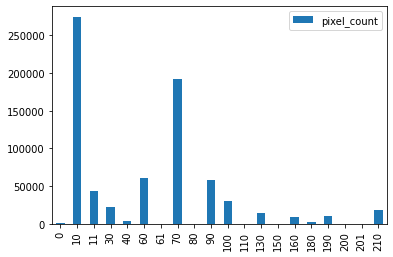

In [27]:
#plot pixel distribution
classes_df_2015.plot.bar()

In [28]:
#new classes data
new_roi_2015 = old_to_new_classes(roi)
data_new_2015=[]
new_class_vals = np.unique(new_roi_2015)
for c in new_class_vals:
    data_new_2015.append((new_roi_2015 == c).sum())
new_classes_df = pd.DataFrame(data_new_2015, index = new_class_vals, columns = ['pixel_count'])   
new_classes_df  

,pixel_count
0,1362
1,343416
2,148701
3,191751
4,9329
5,14156
7,10869
8,200
9,17955
10,1827


<AxesSubplot:>

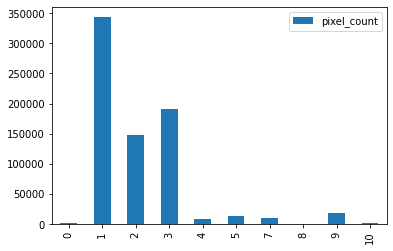

In [29]:
#Plot pixel distribution
new_classes_df.plot.bar()

From this 2015 example you can see that there is some class imbalance in the training data. The above is the pixel count from the original ESA CCI image with the list of proposed new classes. The 'Shrubland' (6) class contains no training data at all and the 'sparse vegetation' (8) class also has a low count. The 'Urban'(7) class has a lower count than other classes but it doesn't appear low enough for the classifier to miss it out completely. The imbalance should be addressed in training as classes 1,2,3 vastly outweigh the rest.

#### Look at 1992 where urban area disappears

In [30]:
roi_92 = xr.open_rasterio('/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/esa_cci_rois/esa_cci_1992_chernobyl.geojson')
classes_92 = np.unique(roi_92)

In [31]:
#esa cci classes
data_92 = []
for c in classes_92:
    data_92.append((roi_92 == c).sum())
classes_df_92 = pd.DataFrame(data_92, index = classes_92, columns = ['pixel_count'])   
classes_df_92  

,pixel_count
0,1362
10,271374
11,42674
30,25319
40,37681
60,49043
61,205
70,191598
80,2
90,52761


<AxesSubplot:>

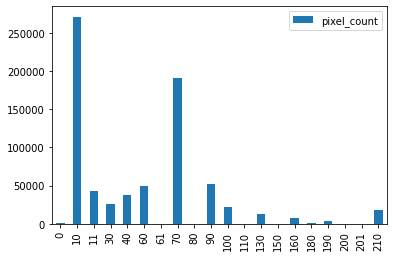

In [32]:
#Visualize
classes_df_92.plot.bar()

In [33]:
#new classes
new_roi_92 = old_to_new_classes(roi_92)
data_new_92=[]
new_class_vals = np.unique(new_roi_2015)
for c in new_class_vals:
    data_new_92.append((new_roi_92 == c).sum())
new_classes_df_92 = pd.DataFrame(data_new_92, index = new_class_vals, columns = ['pixel_count'])   
new_classes_df_92

,pixel_count
0,1362
1,377048
2,123674
3,191598
4,8236
5,13489
7,4292
8,236
9,17947
10,1684


<AxesSubplot:>

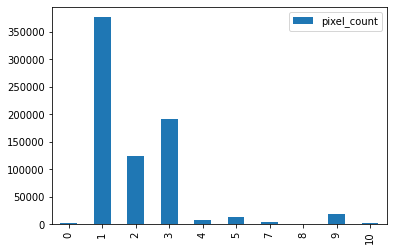

In [34]:
new_classes_df_92.plot.bar()

There are some urban pixels in 1992 but far fewer than in 2015. Aside from that large change the general balance of classes appears consistent. May need to remove shrubland class since it appears to be irrelevant for our area.

In [ ]:
#from src.models.xgb import return_normalized_array, timeit

To do: Formulate method for sampling y-pixels at 30m resolution

Could use stratified sampling from ESA CCI and then map to Landsat?

In [37]:
filename = os.path.join( SAT_DIR + '/inputs/take_esa_coords_True_use_mfd_False_use_ffil_True_y.nc')
y_preds = xr.open_dataset(filename)
print(y_preds)

<xarray.Dataset>
Dimensions:  (x: 1086, y: 681, year: 24)
Coordinates:
    band     int64 ...
  * y        (y) float64 52.43 52.43 52.43 52.43 ... 50.55 50.55 50.55 50.55
  * x        (x) float64 28.41 28.41 28.41 28.42 ... 31.41 31.42 31.42 31.42
  * year     (year) int64 1992 1993 1994 1995 1996 ... 2011 2012 2013 2014 2015
Data variables:
    esa_cci  (year, y, x) uint8 ...
